In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=9fc8c673425eef1c911f524ce6c96160083cf574fb8d7cb729c93987abb77091
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, year

#from pyspark.ml.regression import LinearRegression


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd /content/drive/My Drive/CSCI 436 BIOGAS PROJECT/
!ls

/content/drive/My Drive/CSCI 436 BIOGAS PROJECT
caiso_2021-22.csv		  CaliTempV1.ipynb	    CSCI_436_PROJECT_REPORT.gdoc
CaliData_LinearRegression.ipynb   CaliTempV2.ipynb	    DecisionTreeRegression.ipynb
Cali-GAS-MVF-10-Year-Report.xlsx  Clustering.ipynb	    LinearRegression.ipynb
CaliRenewProd2010-18.csv	  CSCI_436_PROJECT.gslides


In [7]:
df2 = pd.read_csv('/content/drive/My Drive/CSCI 436 BIOGAS PROJECT/caiso_2021-22.csv')
df1 = pd.read_csv('/content/drive/My Drive/CSCI 436 BIOGAS PROJECT/CaliRenewProd2010-18.csv')
#header=True, inferSchema=True)

In [8]:
# df1['TIMESTAMP'] = pd.to_datetime(df1['TIMESTAMP'])
# df2['DateTime'] = pd.to_datetime(df2['DateTime'])
# df1['Timestamp'] = df1['TIMESTAMP']
# df2['Timestamp'] = df2['DateTime']

df1['TIMESTAMP'] = pd.to_datetime(df1['TIMESTAMP'])
df1['Unified_Timestamp'] = df1['TIMESTAMP']
df1.rename(columns={'BIOGAS': 'Biogas', 'BIOMASS': 'Biomass', 'TIMESTAMP': 'DateTime'}, inplace=True)

In [9]:
df2['DateTime'] = pd.to_datetime(df2['DateTime'])
df2['Unified_Timestamp'] = df2['DateTime']

In [10]:
print(df1.columns)

Index(['DateTime', 'Biogas', 'Biomass', 'GEOTHERMAL', 'Hour', 'SMALL HYDRO',
       'SOLAR', 'SOLAR PV', 'SOLAR THERMAL', 'WIND TOTAL',
       'Unified_Timestamp'],
      dtype='object')


In [11]:
#print(df2.head(3))
print(df2.columns)

Index(['Unnamed: 0', 'Date', 'Time', 'Solar', 'Wind', 'Geothermal', 'Biomass',
       'Biogas', 'Small hydro', 'Coal', 'Nuclear', 'Natural Gas',
       'Large Hydro', 'Batteries', 'Imports', 'Other', 'DateTime', 'Month',
       'Year', 'Unified_Timestamp'],
      dtype='object')


In [12]:
print("Missing values for 2010-18")
print(df1.isnull().sum())
print("\n Missing values for 2021-22")
print(df2.isnull().sum())

Missing values for 2010-18
DateTime                 0
Biogas                   0
Biomass                  0
GEOTHERMAL               0
Hour                     0
SMALL HYDRO              0
SOLAR                44904
SOLAR PV             22680
SOLAR THERMAL        22680
WIND TOTAL               0
Unified_Timestamp        0
dtype: int64

 Missing values for 2021-22
Unnamed: 0            0
Date                  0
Time                  0
Solar                12
Wind                 12
Geothermal           12
Biomass              12
Biogas               12
Small hydro          12
Coal                 12
Nuclear              12
Natural Gas          12
Large Hydro          12
Batteries            12
Imports              12
Other                12
DateTime              0
Month                 0
Year                  0
Unified_Timestamp     0
dtype: int64


In [13]:
df1.rename(columns={'BIOGAS': 'Biogas', 'BIOMASS': 'Biomass', 'TIMESTAMP': 'DateTime'}, inplace=True)

In [14]:
#connect the two datasets
df = pd.concat([df1, df2])

In [15]:
print(df.columns)

Index(['DateTime', 'Biogas', 'Biomass', 'GEOTHERMAL', 'Hour', 'SMALL HYDRO',
       'SOLAR', 'SOLAR PV', 'SOLAR THERMAL', 'WIND TOTAL', 'Unified_Timestamp',
       'Unnamed: 0', 'Date', 'Time', 'Solar', 'Wind', 'Geothermal',
       'Small hydro', 'Coal', 'Nuclear', 'Natural Gas', 'Large Hydro',
       'Batteries', 'Imports', 'Other', 'Month', 'Year'],
      dtype='object')


In [16]:
print(df.head(4))

             DateTime  Biogas  Biomass  GEOTHERMAL  Hour  SMALL HYDRO  SOLAR  \
0 2011-07-21 00:00:00   177.0    372.0       984.0   1.0        516.0    0.0   
1 2011-07-21 01:00:00   176.0    373.0       984.0   2.0        509.0    0.0   
2 2011-07-21 02:00:00   177.0    371.0       985.0   3.0        506.0    0.0   
3 2011-07-21 03:00:00   177.0    374.0       985.0   4.0        504.0    0.0   

   SOLAR PV  SOLAR THERMAL  WIND TOTAL  ... Small hydro  Coal Nuclear  \
0       NaN            NaN      1607.0  ...         NaN   NaN     NaN   
1       NaN            NaN      1619.0  ...         NaN   NaN     NaN   
2       NaN            NaN      1660.0  ...         NaN   NaN     NaN   
3       NaN            NaN      1633.0  ...         NaN   NaN     NaN   

  Natural Gas  Large Hydro  Batteries  Imports  Other  Month  Year  
0         NaN          NaN        NaN      NaN    NaN    NaN   NaN  
1         NaN          NaN        NaN      NaN    NaN    NaN   NaN  
2         NaN          NaN

In [17]:
print(df.iloc[79999]) #concat test to see its in df

DateTime             2021-10-14 02:35:00
Biogas                             201.0
Biomass                            275.0
GEOTHERMAL                           NaN
Hour                                 NaN
SMALL HYDRO                          NaN
SOLAR                                NaN
SOLAR PV                             NaN
SOLAR THERMAL                        NaN
WIND TOTAL                           NaN
Unified_Timestamp    2021-10-14 02:35:00
Unnamed: 0                          31.0
Date                          2021-10-14
Time                               02:35
Solar                              -40.0
Wind                              1406.0
Geothermal                         756.0
Small hydro                        108.0
Coal                                18.0
Nuclear                           2272.0
Natural Gas                       9467.0
Large Hydro                       1243.0
Batteries                          -21.0
Imports                           4992.0
Other           

# **Statistics**

In [18]:
df_describe = df.describe()
df_transpose = df_describe.transpose()

In [19]:
print(df_transpose)

                      count                           mean  \
DateTime             172688  2019-01-15 17:20:58.273880832   
Biogas             172676.0                     192.361424   
Biomass            172676.0                     293.736508   
GEOTHERMAL          67584.0                     958.105921   
Hour                67584.0                           12.5   
SMALL HYDRO         67584.0                     314.210193   
SOLAR               22680.0                     162.843757   
SOLAR PV            44904.0                    1647.195706   
SOLAR THERMAL       44904.0                     117.254521   
WIND TOTAL          67584.0                     1286.50648   
Unified_Timestamp    172688  2019-01-15 17:20:58.273880832   
Unnamed: 0         105104.0                     143.478231   
Solar              105092.0                    4193.116555   
Wind               105092.0                    2454.372731   
Geothermal         105092.0                     869.873949   
Small hy

In [20]:
#df_filled = df.fillna(df.mean())
df['Biogas'].fillna(df['Biogas'].mean(), inplace=True)
df['Biomass'].fillna(df['Biomass'].mean(), inplace=True)
df['Natural Gas'].fillna(df['Natural Gas'].mean(), inplace=True)

In [21]:
#df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Time'] = pd.to_datetime(df['Unified_Timestamp']).dt.year

In [22]:
print(df.head())

             DateTime  Biogas  Biomass  GEOTHERMAL  Hour  SMALL HYDRO  SOLAR  \
0 2011-07-21 00:00:00   177.0    372.0       984.0   1.0        516.0    0.0   
1 2011-07-21 01:00:00   176.0    373.0       984.0   2.0        509.0    0.0   
2 2011-07-21 02:00:00   177.0    371.0       985.0   3.0        506.0    0.0   
3 2011-07-21 03:00:00   177.0    374.0       985.0   4.0        504.0    0.0   
4 2011-07-21 04:00:00   177.0    377.0       984.0   5.0        508.0    0.0   

   SOLAR PV  SOLAR THERMAL  WIND TOTAL  ... Small hydro  Coal Nuclear  \
0       NaN            NaN      1607.0  ...         NaN   NaN     NaN   
1       NaN            NaN      1619.0  ...         NaN   NaN     NaN   
2       NaN            NaN      1660.0  ...         NaN   NaN     NaN   
3       NaN            NaN      1633.0  ...         NaN   NaN     NaN   
4       NaN            NaN      1520.0  ...         NaN   NaN     NaN   

   Natural Gas  Large Hydro  Batteries  Imports  Other  Month  Year  
0  8614.64

In [23]:
print(df.isnull().sum()) #should clean missing for three columns

DateTime                  0
Biogas                    0
Biomass                   0
GEOTHERMAL           105104
Hour                 105104
SMALL HYDRO          105104
SOLAR                150008
SOLAR PV             127784
SOLAR THERMAL        127784
WIND TOTAL           105104
Unified_Timestamp         0
Unnamed: 0            67584
Date                  67584
Time                      0
Solar                 67596
Wind                  67596
Geothermal            67596
Small hydro           67596
Coal                  67596
Nuclear               67596
Natural Gas               0
Large Hydro           67596
Batteries             67596
Imports               67596
Other                 67596
Month                 67584
Year                  67584
dtype: int64


In [24]:
spark = SparkSession.builder \
    .appName("Predict Biogas Production") \
    .getOrCreate()

In [25]:
df_spark = spark.createDataFrame(df)

In [26]:
print(df.head())

             DateTime  Biogas  Biomass  GEOTHERMAL  Hour  SMALL HYDRO  SOLAR  \
0 2011-07-21 00:00:00   177.0    372.0       984.0   1.0        516.0    0.0   
1 2011-07-21 01:00:00   176.0    373.0       984.0   2.0        509.0    0.0   
2 2011-07-21 02:00:00   177.0    371.0       985.0   3.0        506.0    0.0   
3 2011-07-21 03:00:00   177.0    374.0       985.0   4.0        504.0    0.0   
4 2011-07-21 04:00:00   177.0    377.0       984.0   5.0        508.0    0.0   

   SOLAR PV  SOLAR THERMAL  WIND TOTAL  ... Small hydro  Coal Nuclear  \
0       NaN            NaN      1607.0  ...         NaN   NaN     NaN   
1       NaN            NaN      1619.0  ...         NaN   NaN     NaN   
2       NaN            NaN      1660.0  ...         NaN   NaN     NaN   
3       NaN            NaN      1633.0  ...         NaN   NaN     NaN   
4       NaN            NaN      1520.0  ...         NaN   NaN     NaN   

   Natural Gas  Large Hydro  Batteries  Imports  Other  Month  Year  
0  8614.64

In [27]:
#df_spark = df_spark.withColumnRenamed('Biogas', 'label')


In [28]:
featuredColumns = ['Time', 'Biogas', 'Biomass', 'Natural Gas'] #DateTime

In [29]:
assembler = VectorAssembler(inputCols=featuredColumns, outputCol='features')


In [30]:
#df_spark = df_spark.withColumn('Gas Production', 'label')
#df_spark = df_spark.withColumn("label", df_spark["Biogas"])

In [31]:
#dtree = DecisionTreeRegressor(featuresCol='features', labelCol='label', maxDepth= 5)
#start the model
dtree = DecisionTreeRegressor(featuresCol='features', labelCol='Biogas', maxDepth=5)


In [32]:
pipeline = Pipeline(stages=[assembler, dtree])

In [33]:
print(df.head())

             DateTime  Biogas  Biomass  GEOTHERMAL  Hour  SMALL HYDRO  SOLAR  \
0 2011-07-21 00:00:00   177.0    372.0       984.0   1.0        516.0    0.0   
1 2011-07-21 01:00:00   176.0    373.0       984.0   2.0        509.0    0.0   
2 2011-07-21 02:00:00   177.0    371.0       985.0   3.0        506.0    0.0   
3 2011-07-21 03:00:00   177.0    374.0       985.0   4.0        504.0    0.0   
4 2011-07-21 04:00:00   177.0    377.0       984.0   5.0        508.0    0.0   

   SOLAR PV  SOLAR THERMAL  WIND TOTAL  ... Small hydro  Coal Nuclear  \
0       NaN            NaN      1607.0  ...         NaN   NaN     NaN   
1       NaN            NaN      1619.0  ...         NaN   NaN     NaN   
2       NaN            NaN      1660.0  ...         NaN   NaN     NaN   
3       NaN            NaN      1633.0  ...         NaN   NaN     NaN   
4       NaN            NaN      1520.0  ...         NaN   NaN     NaN   

   Natural Gas  Large Hydro  Batteries  Imports  Other  Month  Year  
0  8614.64

In [34]:
model = pipeline.fit(df_spark)


In [35]:
#predict = model.transform(df_spark)

In [36]:
#df_pred_2030 = model.transform(df_spark).toPandas()
prediction = model.transform(df_spark).toPandas()

In [37]:
import matplotlib.pyplot as plt

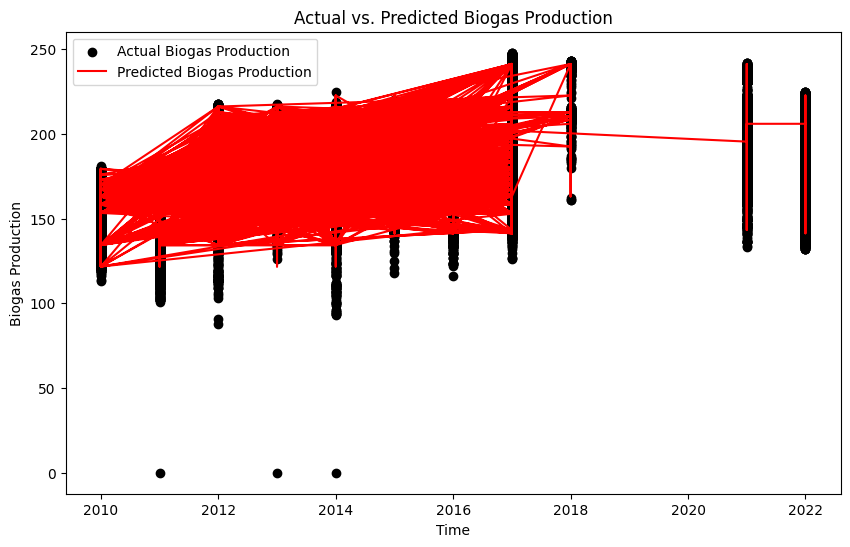

In [38]:
#predict.select("Time", "Biogas", "prediction").show()
plt.figure(figsize=(10, 6))
plt.scatter(prediction['Time'], prediction['Biogas'], label='Actual Biogas Production', color='black')
plt.plot(prediction['Time'], prediction['prediction'], label='Predicted Biogas Production', color='red')
plt.xlabel('Time')
plt.ylabel('Biogas Production (MW)')
plt.title('Actual vs. Predicted Biogas Production')
plt.legend()
plt.show()

**the red is the prediction from the model, if its matching close to black then the prediction is good from actual biogas production**

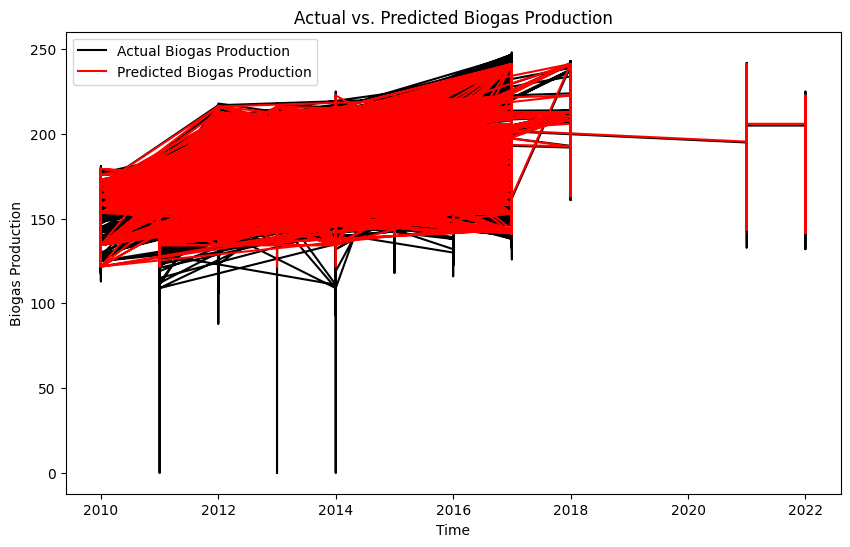

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(prediction['Time'], prediction['Biogas'], label='Actual Biogas Production', color='black')
plt.plot(prediction['Time'], prediction['prediction'], label='Predicted Biogas Production', color='red')
plt.xlabel('Time')
plt.ylabel('Biogas Production (MW)')
plt.title('Actual vs. Predicted Biogas Production')
plt.legend()
plt.show()

Noisy? or overfitting?

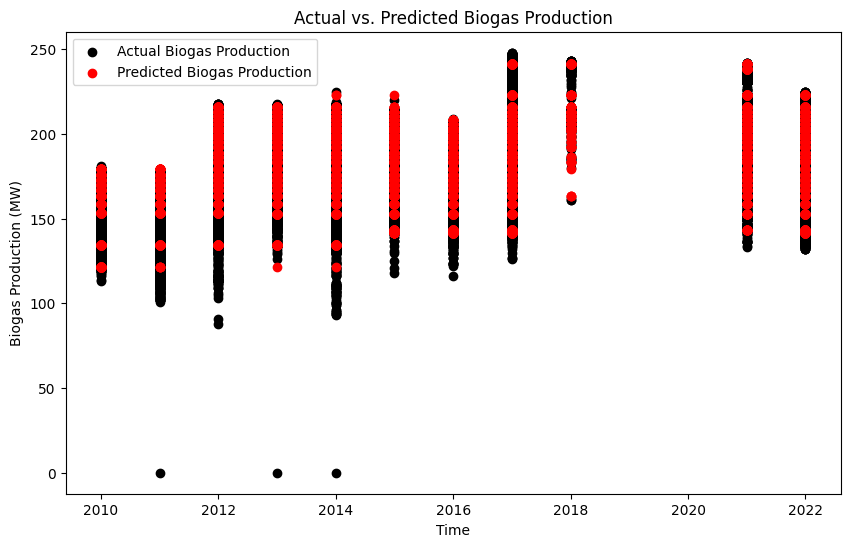

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(prediction['Time'], prediction['Biogas'], label='Actual Biogas Production', color='black')
plt.scatter(prediction['Time'], prediction['prediction'], label='Predicted Biogas Production', color='red')
plt.xlabel('Time')
plt.ylabel('Biogas Production (MW)')
plt.title('Actual vs. Predicted Biogas Production')
plt.legend()
plt.show()

low accuracy

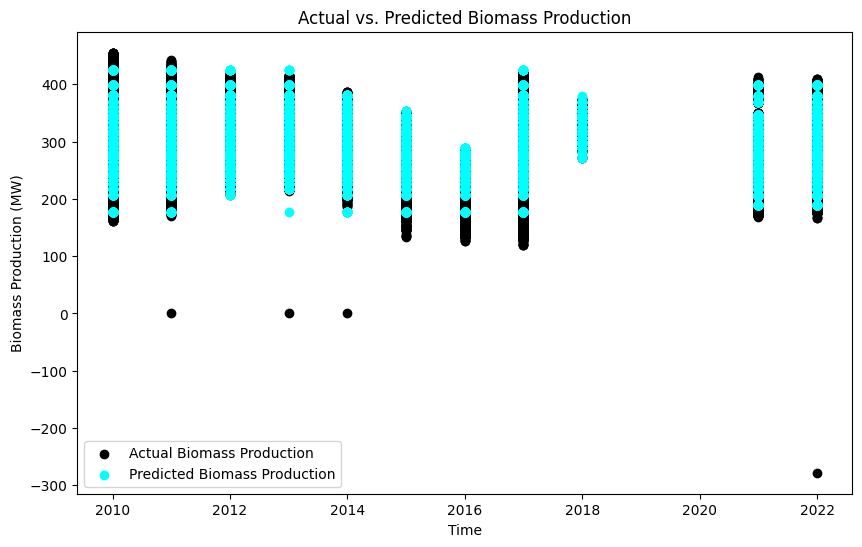

In [57]:


dtree = DecisionTreeRegressor(featuresCol='features', labelCol='Biomass', maxDepth=5)
pipeline = Pipeline(stages=[assembler, dtree])
model = pipeline.fit(df_spark)
prediction = model.transform(df_spark).toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(prediction['Time'], prediction['Biomass'], label='Actual Biomass Production', color='black')
plt.scatter(prediction['Time'], prediction['prediction'], label='Predicted Biomass Production', color='cyan')
plt.xlabel('Time')
plt.ylabel('Biomass Production (MW)')
plt.title('Actual vs. Predicted Biomass Production')
plt.legend()
plt.show()

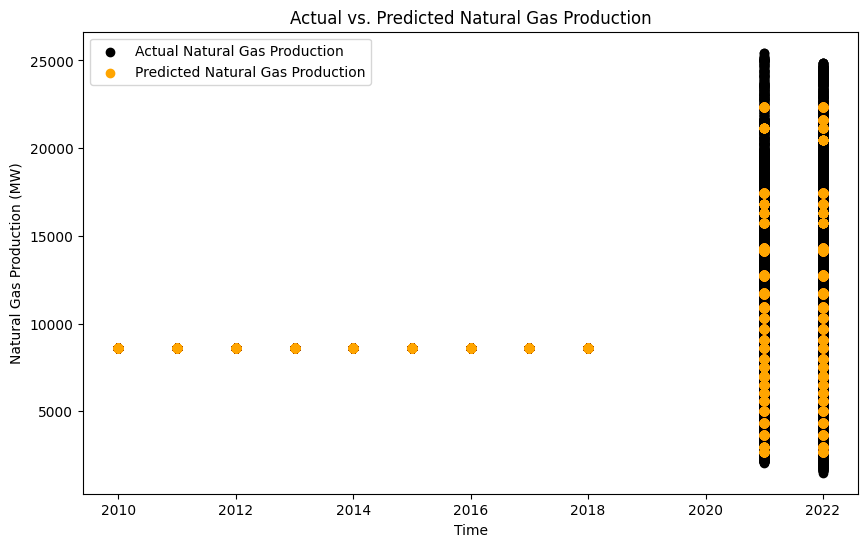

In [56]:
dtree = DecisionTreeRegressor(featuresCol='features', labelCol='Natural Gas', maxDepth=5)
pipeline = Pipeline(stages=[assembler, dtree])
model = pipeline.fit(df_spark)
prediction = model.transform(df_spark).toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(prediction['Time'], prediction['Natural Gas'], label='Actual Natural Gas Production', color='black')
plt.scatter(prediction['Time'], prediction['prediction'], label='Predicted Natural Gas Production', color='orange')
plt.xlabel('Time')
plt.ylabel('Natural Gas Production (MW)')
plt.title('Actual vs. Predicted Natural Gas Production')
plt.legend()
plt.show()

# Notice how it is plotting a predicting on the graph where no actual dataset exists. Natural Gas exists only between 2020-2022